![Logo dell'Università XYZ](img/logo.jpg)

# Advanced Financial Modeling Course

## Introduction

This notebook is part of the teaching material of the Advanced Financial Modeling course! In this series of Jupyter notebooks, we will cover various topics related to financial modeling, including fundamental concepts, practical applications, and hands-on exercises.

### Notebooks Overview

1. [Notebook 1: Curve Building](notebooks/notebook1.ipynb)
2. [Notebook 2: AAD Greeks](notebooks/notebook2.ipynb)
3. [Notebook 3: Swap AAD Sensitivities](notebooks/notebook3.ipynb)
3. [Notebook 4: Simulation of Extended Short-Rate Models](notebooks/notebook3.ipynb)
4. [Notebook 5: Model Calibration](notebooks/notebook4.ipynb)
5. [Notebook 6: SABR stochastic volatility](notebooks/notebook5.ipynb)
5. [Notebook 7: xVA--CCR simulation](notebooks/notebook5.ipynb)


## Notebook 1: Curve Building 

This notebook provides an in-depth exploration of curve building in the context of interest rate modeling. We'll cover fundamental concepts and techniques for constructing interest rate curves, with a practical example focused on the EUR market.

### Topics Covered

- Understanding interest rate curves and their significance in financial modeling.
- Utilizing QuantLib library to handle financial data and perform curve building tasks.
- Principles of discounting and forwarding, essential for curve construction and valuation.
- Interpolation methods for smoothing and extrapolating curve data.




## References
- Balaraman, G., and Ballabio, L. . Quantlib Python Cookbook (2019)
- Ametrano, F. M., and Bianchetti, M. (2013). Everything you always wanted to know about multiple interest rate curve bootstrapping but were afraid to ask. Available at SSRN 2219548.

## Import Libraries

In [1]:
import QuantLib as ql
import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
matplotlib.rcParams['font.family'] = 'serif'

## Load market data

In [3]:
today = ql.Date(22, ql.February, 2023)
daycounter = ql.ActualActual()
ql.Settings.instance().evaluationDate = today
estr_curve_df = pd.read_excel('data/curve_EUR_20230222.xlsx', sheet_name=0)
eur6m_curve_df = pd.read_excel('data/curve_EUR_20230222.xlsx', sheet_name=1)

## Build a discount curve

The first three instruments are three **1-day deposit** that give us discounting between today and the
day after spot. They are modeled by three instances of the DepositRateHelper class with a tenor of
1 day and a number of fixing days going from 0 (for the deposit starting today) to 2 (for the deposit
starting on the spot date). <br>
Then, we have a series of **OIS quotes** for 1W tenors up to 60Y. They are modeled by instances of the
_OISRateHelper_ class with varying tenors. They also require an instance of the _Estr_, which
doesn’t need a forecast (estimation/forwarding) curve and can be shared between the helpers

In [4]:
estr_curve_df

,Tp,Start date,Generator,Maturity,Maturity.1,ds.factor,ds.rate,Market quote,Curve spread,Selected
0,Dp,2023-02-22,DEPO ESTR_C,2023-02-23,O/N,0.999933,2.433252,2.400000,0,Y
1,Dp,2023-02-23,DEPO ESTR_C,2023-02-24,T/N,0.999867,2.433252,2.400000,0,Y
2,Dp,2023-02-24,DEPO ESTR_C,2023-02-27,S/N,0.999667,2.433115,2.399934,0,Y
3,Sw,2023-02-24,SWP ESTR DISC_C,2023-03-03,1W,0.999400,2.432874,2.400000,0,Y
4,Sw,2023-02-24,SWP ESTR DISC_C,2023-03-10,2W,0.998934,2.432330,2.400000,0,Y
...,...,...,...,...,...,...,...,...,...,...
57,Sw,2023-02-24,SWP ESTR DISC_C,2053-02-24,30Y,0.483102,2.422881,2.521000,0,Y
58,Sw,2023-02-24,SWP ESTR DISC_C,2058-02-25,35Y,0.444889,2.311915,2.430628,0,Y
59,Sw,2023-02-24,SWP ESTR DISC_C,2063-02-26,40Y,0.409805,2.228047,2.362000,0,Y
60,Sw,2023-02-24,SWP ESTR DISC_C,2073-02-24,50Y,0.355716,2.065547,2.235000,0,Y


In [5]:
deposit_quotes = estr_curve_df[estr_curve_df['Tp'] == 'Dp']['Market quote']/100
ois_quotes = estr_curve_df[estr_curve_df['Tp']== 'Sw'][['Maturity.1', 'Market quote']]

helpers = [
            ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate)),
            ql.Period(1,ql.Days), fixingDays,
            ql.TARGET(), ql.Following,
            False, ql.Actual360())
            for rate, fixingDays in [(deposit_quotes[0], 0), (deposit_quotes[1], 1), (deposit_quotes[2], 2)]
            ]


estr = ql.Estr() # indexed to Estr Risk-Free-Rate
for i in range(len(ois_quotes)):
    tenor = ql.Period(ois_quotes.iloc[i,:]['Maturity.1'])
    rate = ois_quotes.iloc[i,:]['Market quote']/100
    helpers += [ql.OISRateHelper(2, tenor,ql.QuoteHandle(ql.SimpleQuote(rate)), estr)]
    

In [6]:
estr_curve_c = ql.PiecewiseLogCubicDiscount(0, ql.TARGET(),helpers, ql.Actual365Fixed())
estr_curve_c.enableExtrapolation()

In [7]:
today = estr_curve_c.referenceDate()
end = today + ql.Period(30,ql.Years)

dates = [ ql.Date(serial) for serial in range(today.serialNumber(),end.serialNumber()+1) ] # just a list of dates
taus = [daycounter.yearFraction(today, d) for d in dates] # array of tau (in years)


estr_fwd_curve = [ estr_curve_c.forwardRate(d, ql.TARGET().advance(d,1,ql.Days), ql.Actual360(), ql.Simple).rate()
                    for d in dates ]
estr_zero_curve = [ estr_curve_c.zeroRate(d, ql.Actual360(), ql.Simple).rate()
                    for d in dates ]

# Impact of Interpolation 

Consider 3 different QuantLib-curve objects using 3 different interpolation functions, _PiecewiseLinearZero_, _PiecewiseFlatForward_ and the _PiecewiseLogCubicDiscount_ (created before)

In [8]:
estr_curve_lin = ql.PiecewiseLinearZero(0, ql.TARGET(),helpers, ql.Actual365Fixed())
estr_curve_lin.enableExtrapolation()

estr_curve_flat = ql.PiecewiseFlatForward(0, ql.TARGET(),helpers, ql.Actual365Fixed())
estr_curve_flat.enableExtrapolation()

today = estr_curve_c.referenceDate()
end = today + ql.Period(30,ql.Years)

dates = [ ql.Date(serial) for serial in range(today.serialNumber(),end.serialNumber()+1) ] # just a list of dates
taus = [daycounter.yearFraction(today, d) for d in dates] # array of tau (in years)

### forward curves 
# use the previous instances of the 3 curves to build 3 array of forward rates (3 forward curves with observations in taus)
estr_fwd_curve = [ estr_curve_c.forwardRate(d, ql.TARGET().advance(d,1,ql.Days), ql.Actual360(), ql.Simple).rate()
                    for d in dates ]

estr_fwd_curve_lin = [ estr_curve_lin.forwardRate(d, ql.TARGET().advance(d,1,ql.Days), ql.Actual360(), ql.Simple).rate()
                    for d in dates ]

estr_fwd_curve_flat = [ estr_curve_flat.forwardRate(d, ql.TARGET().advance(d,1,ql.Days), ql.Actual360(), ql.Simple).rate()
                    for d in dates ]


### zero curves
# use the previous instances of the 3 curves to build 3 array of zero rates (3 forward curves with observations in taus)
estr_zero_curve = [ estr_curve_c.zeroRate(d, ql.Actual360(), ql.Simple).rate()
                    for d in dates ]
estr_zero_curve_lin = [ estr_curve_lin.zeroRate(d, ql.Actual360(), ql.Simple).rate()
                    for d in dates ]
estr_zero_curve_flat = [ estr_curve_flat.zeroRate(d, ql.Actual360(), ql.Simple).rate()
                    for d in dates ]

Let's plot our discount curve! Interpolation does not matter

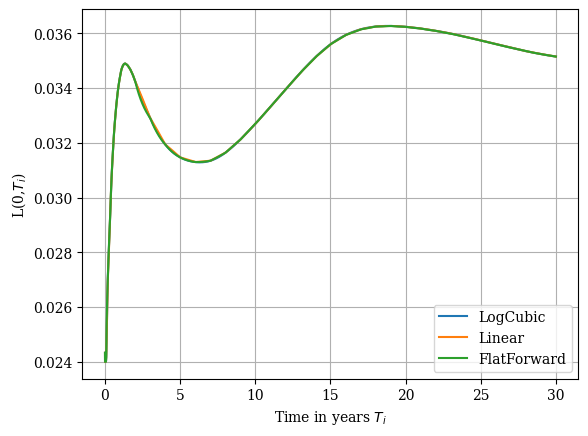

In [9]:
plt.plot(taus, estr_zero_curve, label = 'LogCubic')
plt.plot(taus, estr_zero_curve_lin, label = 'Linear')
plt.plot(taus, estr_zero_curve_flat, label = 'FlatForward')
plt.legend()
plt.grid(True)
plt.xlabel('Time in years $T_i$')
plt.ylabel('L(0,$T_i$)')
plt.show()

Well... yes... but actually NO <br>
let's see forward rates

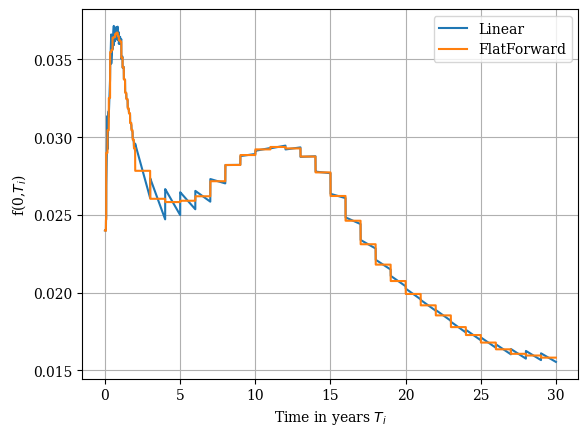

In [10]:
plt.plot(taus, estr_fwd_curve_lin, label = 'Linear')
plt.plot(taus, estr_fwd_curve_flat, label = 'FlatForward')
plt.legend()
plt.grid(True)
plt.xlabel('Time in years $T_i$')
plt.ylabel('f(0,$T_i$)')
plt.show()

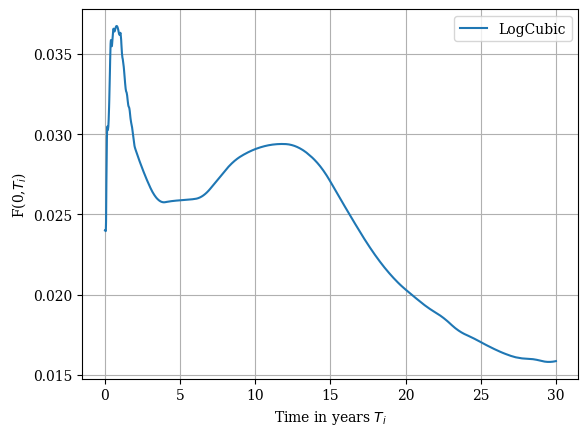

In [11]:
plt.plot(taus, estr_fwd_curve, label = 'LogCubic')
plt.legend()
plt.grid(True)
plt.xlabel('Time in years $T_i$')
plt.ylabel('F(0,$T_i$)')
plt.show()

The short end of the curve is extrapolated backwards from the first quoted pillar at 6 months, this is not quite correct. This leads to oscillations as soon as the curve
is out of the tight strip of FRA quotes. <br>
One way to correct this is to add **synthetic deposits** with short tenors. <br>
However, this topic won't be covered in this course, if you want you can check: F. M. Ametrano and M. Bianchetti,
Everything You Always Wanted to Know About Multiple Interest Rate Curve Bootstrapping but Were
Afraid to Ask (April 2, 2013). The paper is available at SSRN: http://ssrn.com/abstract=2219548.

## Estimation Curve (Forwarding)

Now consider the 6-months EUR curve. cambiare inizio della curva

In [12]:
helpers = [
            ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(2.7729/100)),
                                ql.Period(2,ql.Months), 3, ql.TARGET(), ql.Following, False, ql.Actual360()),
            ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(3.0292/100)),
                                ql.Period(4,ql.Months), 3, ql.TARGET(), ql.Following, False, ql.Actual360()),
            ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(3.2480/100)),
                                ql.Period(6,ql.Months), 3, ql.TARGET(), ql.Following, False, ql.Actual360())
            ]

In [13]:
euribor6m = ql.Euribor6M()

Then comes a strip of 6-months FRA up to 2 years maturity:

In [14]:
fra_quotes = eur6m_curve_df[eur6m_curve_df['Tp']== 'Fr'][['Maturity.1', 'Market quote']]
f_rates = fra_quotes['Market quote'].values

In [15]:
helpers += [
            ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)), start, euribor6m)
            for rate, start in [(f_rates[0], 1), (f_rates[1], 2), (f_rates[2], 3),
                                (f_rates[3], 4), (f_rates[4], 5), (f_rates[5], 6),
                                (f_rates[6], 7), (f_rates[7], 8), (f_rates[8], 9),
                                (f_rates[9], 10), (f_rates[10], 11), (f_rates[11], 12),
                                (f_rates[12], 13), (f_rates[13], 14), (f_rates[14], 15),
                                (f_rates[15], 16), (f_rates[16], 17), (f_rates[17], 18), (f_rates[18], 24)]
            ]

In [16]:
discount_curve = ql.RelinkableYieldTermStructureHandle()
discount_curve.linkTo(estr_curve_c)

Finally, we have a series of swap rates with maturities from 3 to 60 years. <br>
The curve being bootstrapped **will be used only for forecasting** the 6-months Euribor
fixings paid by the floating leg. <br>
**All the payments will be discounted by means of the OIS curve**, which
is wrapped in a Handle and passed as an extra argument to the SwapRateHelper constructor.

In [17]:
swap_quotes = eur6m_curve_df[eur6m_curve_df['Tp']== 'Sw'][['Maturity.1', 'Market quote']]

In [18]:
helpers += [
            ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)),
            ql.Period(tenor, ql.Years), ql.TARGET(),
            ql.Annual, ql.Unadjusted,
            ql.Thirty360(ql.Thirty360.BondBasis),
            euribor6m, ql.QuoteHandle(), ql.Period(0, ql.Days),
            discount_curve)
            for rate, tenor in [(3.422, 3), (3.299, 4), (3.22, 5),
                                (3.168, 6), (3.13, 7), (3.112, 8),
                                (3.103, 9), (3.099, 10), (3.093, 12),
                                (3.061, 15), (2.901, 20), (2.721, 25),
                                (2.563, 30), (2.44, 35), (2.333, 40),
                                (2.155, 50), (2.021, 60)]
            ]

In [19]:
euribor6m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(), helpers,ql.Actual365Fixed())
euribor6m_curve.enableExtrapolation()

In [20]:
## zero curve
eur6m_zero_curve = [ euribor6m_curve.zeroRate(d, ql.Actual360(), ql.Simple).rate()
                    for d in dates[3:] ]

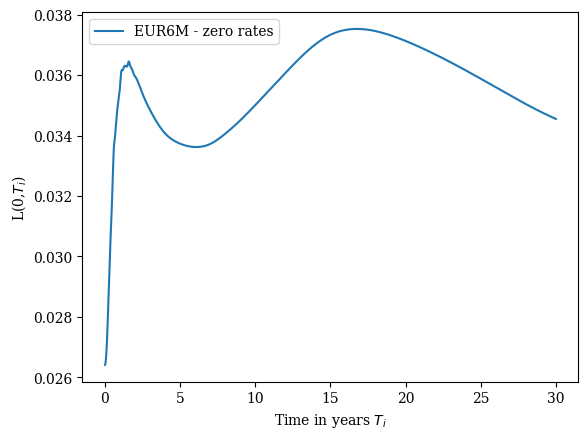

In [21]:
plt.plot(taus[3:], eur6m_zero_curve, label = 'EUR6M - zero rates')
plt.legend()
plt.xlabel('Time in years $T_i$')
plt.ylabel('L(0,$T_i$)')
plt.show()

# Swap Pricing Example

In [22]:
def makeSwap(start, maturity, nominal, fixedRate, index, typ=ql.VanillaSwap.Payer):
    end = ql.TARGET().advance(start, maturity)
    fixedLegTenor = ql.Period("6M")
    fixedLegBDC = ql.ModifiedFollowing
    fixedLegDC = ql.Thirty360(ql.Thirty360.BondBasis)
    spread = 0.0
    fixedSchedule = ql.Schedule(start,
                                end, 
                                fixedLegTenor, 
                                index.fixingCalendar(), 
                                fixedLegBDC,
                                fixedLegBDC, 
                                ql.DateGeneration.Backward,
                                False)
    floatSchedule = ql.Schedule(start,
                                end,
                                index.tenor(),
                                index.fixingCalendar(),
                                index.businessDayConvention(),
                                index.businessDayConvention(),
                                ql.DateGeneration.Backward,
                                False)
    swap = ql.VanillaSwap(typ, 
                          nominal,
                          fixedSchedule,
                          fixedRate,
                          fixedLegDC,
                          floatSchedule,
                          index,
                          spread,
                          index.dayCounter())
    return swap, [index.fixingDate(x) for x in floatSchedule][:-1]

In [23]:
daycount = ql.Actual365Fixed()
calendar = ql.TARGET()

# curva flat
evaluation_date = today
ql.Settings.instance().setEvaluationDate(evaluation_date)

In [24]:
handleYieldTermStructure = ql.RelinkableYieldTermStructureHandle(estr_curve_c)
t0_curve = ql.YieldTermStructureHandle(estr_curve_c)
index = ql.Euribor6M(handleYieldTermStructure)

In [25]:
trade1 = makeSwap(evaluation_date + ql.Period("4d"),
                                  ql.Period("10Y"),
                                  100e6,
                                  0.03,
                                  index)
swap = trade1[0]
fixingDates = trade1[1]

In [26]:
engine = ql.DiscountingSwapEngine(handleYieldTermStructure)
swap.setPricingEngine(engine)
npv = swap.NPV()
print(npv)

-880612.7637591772


In [27]:
swap.fairRate()

0.028975650297369288

In [28]:
swap.fixedLegBPS()

-85967.98158847574

In [29]:
swap.floatingLegBPS()

87227.57099185896